# Facial Detection and Data Generation

In [1]:
# import the necessary packages
import numpy as np
import cv2
from combine import deep_convert
from webimg import url_to_image

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [3]:
image = "https://s1.gossipcop.com/up/2018/12/Katie-Holmes-Jamie-Foxx-Tom-Cruise-Meeting-762x395.jpg"

In [4]:
# image = "/Users/erikni/Downloads/New Training Data as of 10052018/30251 Sad.png"

In [5]:
def convert_single_img(input_img):
    try:
        temp_outs = deep_convert(input_img, pic_id = 0, return_rectangle = True, save_img=False)
        
        for temp_out in temp_outs[1]:
            width = temp_out[1] - temp_out[0]
            height = temp_out[3] - temp_out[2]
            temp_out[0] += round(width * 0.12)
            temp_out[1] -= round(width * 0.12)
            temp_out[2] += round(height * 0.12)
            temp_out[3] -= round(height * 0.12)
        
    except:
        print("fail to find the front face")
        
    return temp_outs

In [6]:
temp_out = deep_convert(image, pic_id = 0, return_rectangle = True, save_img=False)

In [7]:
print(temp_out)

([array([101, 105, 107, ...,  11,  13,  16], dtype=uint8), array([60, 64, 59, ..., 85, 58, 42], dtype=uint8), array([64, 65, 61, ..., 65, 65, 65], dtype=uint8)], [[551, 712, 18, 179, 762], [308, 466, 28, 186, 762], [68, 224, 25, 181, 762]])


In [8]:
def image_shown(image):
    """
    CV2 package use BGR, matplotlib use RGB
    """
    try:
        temp_out = convert_single_img(image)
    except:
        None
    print(temp_out)
    img = url_to_image(image)
    green = (0, 255, 0)
    face_num = 0
    for temp in temp_out[1]:
        left, right, up, down = temp[0:4]
        cv2.rectangle(img, (left, up), (right, down), green, thickness=3)
        face_num += 1
        cv2.putText(img, "Person" + str(face_num), (left, up - 20),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.imwrite("outputimage.jpg", img)
    img=mpimg.imread("outputimage.jpg")
    plt.imshow(img)

([array([101, 105, 107, ...,  11,  13,  16], dtype=uint8), array([60, 64, 59, ..., 85, 58, 42], dtype=uint8), array([64, 65, 61, ..., 65, 65, 65], dtype=uint8)], [[570, 693, 37, 160, 762], [327, 447, 47, 167, 762], [87, 205, 44, 162, 762]])


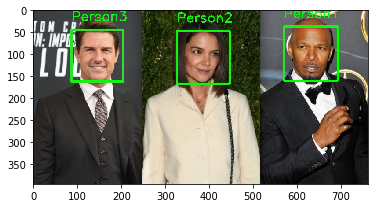

In [9]:
image_shown(image)

In [10]:
test_img_data = convert_single_img(image)[0]
print(test_img_data)

[array([101, 105, 107, ...,  11,  13,  16], dtype=uint8), array([60, 64, 59, ..., 85, 58, 42], dtype=uint8), array([64, 65, 61, ..., 65, 65, 65], dtype=uint8)]


In [11]:
# convert np data type into int data type for json

push_data = []
for single_img_data in test_img_data:
    temp = single_img_data.reshape(200,200)
    single_push_data = []
    for i in temp:
        row = []
        for j in i:
            row.append([int(j)])
        single_push_data.append(row)
    push_data.append(single_push_data)    
"""
for i in test_img_data:
    push_data.append(int(i))
"""


'\nfor i in test_img_data:\n    push_data.append(int(i))\n'

In [12]:
push_data_np = np.array(push_data)

In [13]:
# need a 1*200*200*1 input
push_data_np.shape

(3, 200, 200, 1)

# Use Rest API to Get Prediction

In [14]:
import requests
import json

In [15]:
url = "http://35.224.178.33:8501/v1/models/my_model/Models/1"

In [16]:
r = requests.get(url)
print (r)

<Response [400]>


In [17]:
# convert data into json
for i in push_data:

    data = {"instances":[i]}

    push_data_json = json.dumps(data, sort_keys=True, separators=(',', ': '))

    """
    with open('data.json', 'w') as outfile:
        json.dump(push_data_json, outfile)
    """
    #print(push_data_json)
    
    r = requests.post("http://35.224.178.33:8501/v1/models/Models:predict", data=push_data_json)
    print(r.text)

{
    "predictions": [[0.20836, 0.151425, 0.152794, 0.116823, 0.00107293, 0.0730609, 0.0543542, 0.24211]
    ]
}
{
    "predictions": [[0.177562, 0.311491, 0.0469016, 0.0135017, 0.215837, 0.0041405, 0.0396851, 0.190881]
    ]
}
{
    "predictions": [[0.000281933, 0.00938504, 0.0945305, 5.32192e-05, 0.895009, 1.31764e-05, 0.000615407, 0.000112144]
    ]
}
